In [138]:
import os
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
from lmfit import models
from pathlib import Path
from astropy.io import fits
import scipy.constants as sc
import astropy.constants as ac

In [139]:
def import_files(path, filename):
    '''
    Import files in the syntax that I used in the notebook. That is, choose the path that contains
    all the fit files, then for the filename choose something like bias* to obtain all bias files
    as a dictionary that can be accessed by filename 
    '''
    files =  [ p for p in Path(path).glob(filename) ]
    file_dict = dict()
    for file in files:
        file_dict[os.path.basename(file)] = fits.getdata(file) # key of the dict is the filename.

    headers_dict = dict()
    for x in file_dict.keys():
        headers_dict[x] = fits.getheader(path + x)

    return file_dict, headers_dict 

def get_peak_wavelength(wavelengths, irradiances):
    index = list(irradiances).index(max(irradiances))
    return  wavelengths[index]

def get_effective_temperature(wavelength_peak):
    return ( 2.897771955 * 10**-3 ) / (wavelength_peak * 10**-9)

def stack(values):
    return  np.median( [ x for x in values ], axis=0 )

def planck(temperature, wavelength):
    return (S := (  2 * sc.Planck * sc.speed_of_light ** 2 ) /
        ( (wavelength**5) * ( np.exp( ( sc.Planck * sc.speed_of_light) / ( wavelength * sc.k * temperature ) ) - 1 ) ) )

def planck_scaled(temperature, wavelength):
    return (S := ( ( ( ac.R_sun / ac.au ) ** 2 )  *  ( 2 * sc.Planck * sc.speed_of_light ** 2 ) /
        ( (wavelength**5) * ( np.exp( ( sc.Planck * sc.speed_of_light) / ( wavelength * sc.k * temperature ) ) - 1 ) ) ) )


Import fraunhofer lines

In [140]:
flat_dict, flat_headers = import_files(
    "C:/Users/bvptr/academia/physics/year2/natuurkunde_en_sterrenkunde_practicum2/solar_physics_non_git/solar_physics_data/NP2 zonnefysica/20211112 - LISA daglicht spectra/" ,
    "flat_alt*"
)

light_dict, light_headers = import_files(
    "C:/Users/bvptr/academia/physics/year2/natuurkunde_en_sterrenkunde_practicum2/solar_physics_non_git/solar_physics_data/20201109 sky zenith/" ,
    "skyspectrum*")

dark_dict, dark_headers = import_files(
    "C:/Users/bvptr/academia/physics/year2/natuurkunde_en_sterrenkunde_practicum2/solar_physics_non_git/solar_physics_data/20201109 sky zenith/" ,
    "Dark*"
)

bias_dict, bias_headers = import_files(
    "C:/Users/bvptr/academia/physics/year2/natuurkunde_en_sterrenkunde_practicum2/solar_physics_non_git/solar_physics_data/NP2 zonnefysica/SunsetLISA/" ,
    "bias*"
)

print(
    light_headers['skyspectrum zenit-0001.fit']['IMAGETYP'],
    flat_headers['flat_alt-0001.fit']['IMAGETYP'],
    dark_headers['Dark-0001.fit']['IMAGETYP'],
    bias_headers['bias-001.fit']['IMAGETYP'],
)

Light Frame Light Frame Dark Frame Bias Frame


### Calibration

With Fraunhofer

<Parameter 'slope', value=0.25525659690182534 +/- 0.00116, bounds=[-inf:inf]>
<Parameter 'intercept', value=390.82847973147994 +/- 0.809, bounds=[-inf:inf]>


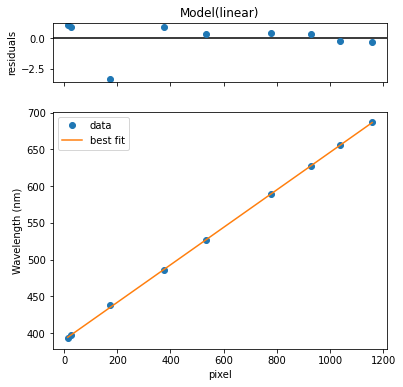

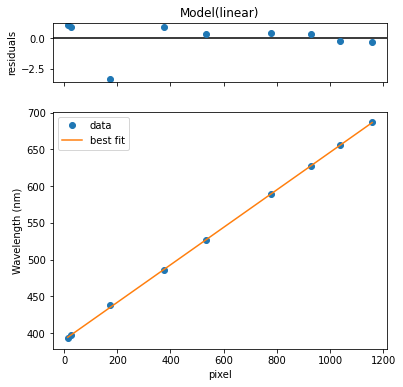

In [141]:
df_fl = pd.read_csv('../data/fraunhofer_lines.csv')
df_fl.keys()

model = models.LinearModel()
fit_pixel_wavelength = model.fit(x=df_fl['pixel'], data=df_fl['wavelength'])
print(fit_pixel_wavelength.params['slope'])
print(fit_pixel_wavelength.params['intercept'])
fit_pixel_wavelength.plot(xlabel='pixel', ylabel='Wavelength (nm)')

In [142]:
fit_pixel_wavelength

### Single fit file case 

`np.median(2darray)` gives the median of all numbers in the 2darray.

`np.median(2darray, axis=0)` gives the medians of the numbers alongside the columns.

`np.median(2darray, axis=1)` gives the medians of the numbers alongside the rows.

`np.sum(2darray)` gives the sum of all numbers in the 2darray.

`np.sum(2darray, axis=0)` gives the sums of the numbers alongside the columns.

`np.sum(2darray, axis=1)` gives the sums of the numbers alongside the rows.


In [143]:
print(type([x for x in light_dict.values()][0][0][0]))

<class 'numpy.uint16'>


In [144]:
flat = fits.getdata("C:/Users/bvptr/academia/physics/year2/natuurkunde_en_sterrenkunde_practicum2/solar_physics_non_git/solar_physics_data/NP2 zonnefysica/20211112 - LISA daglicht spectra/flat_alt-0001.fit" )
light = fits.getdata("C:/Users/bvptr/academia/physics/year2/natuurkunde_en_sterrenkunde_practicum2/solar_physics_non_git/solar_physics_data/20201109 sky zenith/skyspectrum zenit-0001.fit" )

bias_master = stack( bias_dict.values() )

light_sum_before = np.sum(light, axis=0)
light_sum = np.sum( light - bias_master, axis=0)

flat_master_no_bias = np.sum(flat, axis=0)
flat_master = np.sum( flat - bias_master, axis=0)

flat_master_scaled = flat_master / np.median(flat_master)
light_scaled = light_sum / flat_master_scaled


In [145]:
print(type(light), len(light), type(light[0]))
print(type(light_sum), len(light_sum), type(light_sum[0]))
print(type(flat_master), len(flat_master), type(flat_master[0]))
print(type(flat_master_scaled), len(flat_master_scaled), type(flat_master_scaled[0]))
print(type(light_scaled), len(light_scaled), type(light_scaled[0]))

<class 'numpy.ndarray'> 1039 <class 'numpy.ndarray'>
<class 'numpy.ndarray'> 1391 <class 'numpy.float64'>
<class 'numpy.ndarray'> 1391 <class 'numpy.float64'>
<class 'numpy.ndarray'> 1391 <class 'numpy.float64'>
<class 'numpy.ndarray'> 1391 <class 'numpy.float64'>


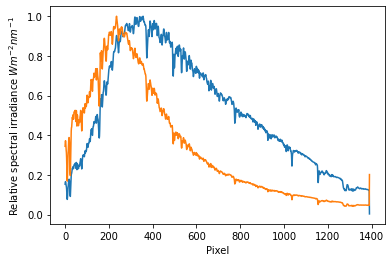

In [146]:
plt.ylabel("Relative spectral irradiance $Wm^{-2}nm^{-1}$")
plt.xlabel("Pixel")
plt.plot(light_sum / np.max(light_sum))
plt.plot(light_scaled / np.max(light_scaled))

### Stacking file case

This is not much differnt; the `flat_stack` and `light_stack` act just like `flat` and `light` above.

In [147]:
flat_stack = stack( flat_dict.values() ) # 1039x1391 2d-array 
light_stack = stack( light_dict.values() ) # 1039x1391 2d-array

bias_master = stack( bias_dict.values() ) # 1039x1391 2d-array

light_sum = np.sum(light_stack - bias_master, axis=0) # 1391 elements 1d-array

flat_master = np.sum(flat_stack - bias_master, axis=0) # 1391 elements 1d-array

flat_master_scaled = flat_master / np.median(flat_master) # 1391 elements 1d-array
light_scaled = light_sum / flat_master_scaled # 1391 elements 1d-array

light_relative = light_sum / np.max(light_sum) # division by the maximum makes it relative.
spectrum = light_scaled_relative = light_scaled / np.max(light_scaled)

In [148]:
print(type(light_stack), len(light_stack), type(light_stack[0]))
print(type(flat_stack), len(flat_stack), type(flat_stack[0]))
print(type(light_sum), len(light_sum), type(light_sum[0]))
print(type(flat_master), len(flat_master), type(flat_master[0]))

<class 'numpy.ndarray'> 1039 <class 'numpy.ndarray'>
<class 'numpy.ndarray'> 1039 <class 'numpy.ndarray'>
<class 'numpy.ndarray'> 1391 <class 'numpy.float64'>
<class 'numpy.ndarray'> 1391 <class 'numpy.float64'>


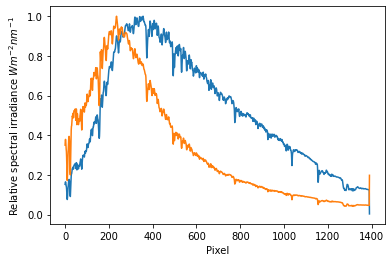

In [149]:
plt.ylabel("Relative spectral irradiance $Wm^{-2}nm^{-1}$")
plt.xlabel("Pixel")
plt.plot(light_relative)
plt.plot(light_scaled_relative)

### Neon calibration

In [150]:
# From ijking.ipynb
slope = 2.57550836 * .1 # convert from angstrom to nm.
intercept = 3888.85008 * .1 # convert from angstrom to nm.

Convert to wavelengths

In [151]:
def pixels_to_wavelenghts(pixels, slope, intercept):
    '''
    This function converts pixel values to wavelengths using a linear model to be determined by a fit.
    '''
    return slope * pixels + intercept
pixels = np.array( range( len( light_scaled_relative ) ) )
wavelengths = pixels_to_wavelenghts(pixels, slope, intercept) # change this literal to a variable

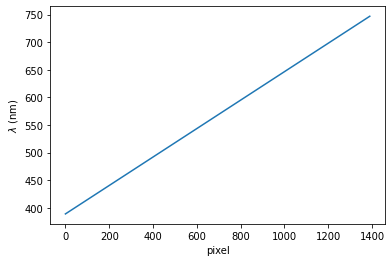

In [152]:
plt.xlabel("pixel")
plt.ylabel("$\lambda$ (nm)")
plt.plot(pixels,wavelengths)

### Crude method to determine effective temperature.

In [177]:
T_accepted = 5772
print(wavelength_peak := get_peak_wavelength(wavelengths, spectrum)) # 481.6998282285298
print(T_eff := get_effective_temperature(wavelength_peak)) # 6015.72137913495
print("%f%% deviation from the accepted value." % float( ( T_eff / T_accepted ) * 100 - 100) ) #4.22% error

449.40945446
6447.955035752187
11.710933% deviation from the accepted value.


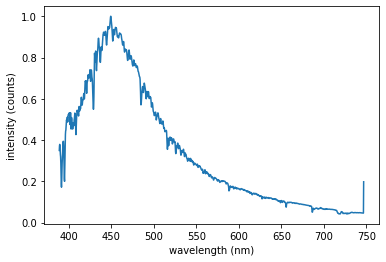

In [154]:
plt.xlabel('wavelength (nm)')
plt.ylabel('intensity (counts)')
plt.plot(wavelengths, spectrum)

In [155]:
df = pd.DataFrame({'spectral irradiance' : spectrum, 'wavelength' : wavelengths})
df.to_csv("../data/to_fit.csv")

### Vega

In [156]:
vega_light = fits.getdata("../data/Vega-0005_2s.fit" )
flat = fits.getdata("../data/flat_alt-0001.fit" )

vega_sum_before_bias = np.sum( vega_light, axis=0 )
vega_sum = np.sum( vega_light - bias_master, axis=0 )

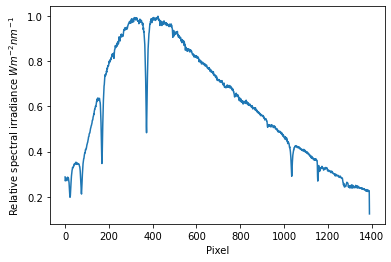

In [157]:
plt.ylabel("Relative spectral irradiance $Wm^{-2}nm^{-1}$")
plt.xlabel("Pixel")
#plt.plot(vega_sum_before_bias / np.max(vega_sum_before_bias))
plt.plot(vega_sum / np.max(vega_sum))

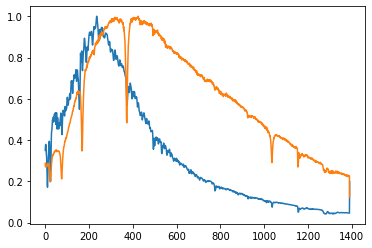

In [158]:
plt.plot(light_scaled_relative)
plt.plot(vega_sum / np.max(vega_sum))

Vega with wavelength

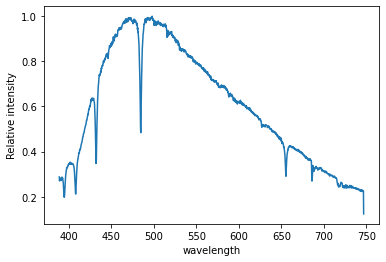

In [159]:
plt.xlabel("wavelength")
plt.ylabel("Relative intensity")
plt.plot( wavelengths, vega_sum / np.max(vega_sum) )

C:\Users\bvptr\AppData\Local\Temp/ipykernel_9552/3053807423.py:30: RuntimeWarning: overflow encountered in exp
  ( (wavelength**5) * ( np.exp( ( sc.Planck * sc.speed_of_light) / ( wavelength * sc.k * temperature ) ) - 1 ) ) )


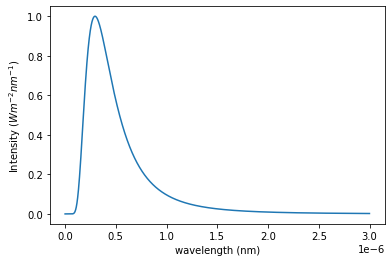

In [160]:
TeffVega = 9800
wvlen = [i * 10 **-9 for i in range(1, 3000)]
I = [ planck(TeffVega, x) for x in wvlen ]
Imax = max(I)
plt.xlabel("wavelength (nm)")
plt.ylabel("Intensity ($W m^{-2} nm^{-1}$)")
plt.plot( wvlen, I / Imax)

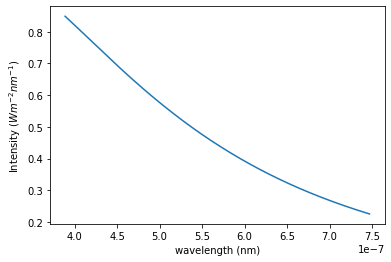

In [168]:
TeffVega = 9800
I_planck_vega = [ planck(TeffVega, x * 10**-9) for x in wavelengths ]
Imax = max(I)
plt.xlabel("wavelength (nm)")
plt.ylabel("Intensity ($W m^{-2} nm^{-1}$)")
plt.plot( [ x * 10**-9 for x in wavelengths ] , I_planck_vega / Imax)

In [169]:
#coeff = I_planck_vega / vega_sum 
coeff = vega_sum / I_planck_vega 
coeff

array([3.46589329e-10, 3.25971486e-10, 3.30493807e-10, ...,
       1.01707849e-09, 1.02582331e-09, 5.61495135e-10])

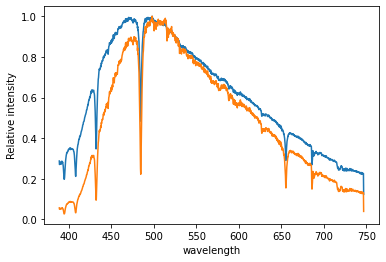

In [170]:

plt.xlabel("wavelength")
plt.ylabel("Relative intensity")
plt.plot( wavelengths, vega_sum / np.max(vega_sum) )
plt.plot( wavelengths, vega_sum * coeff / np.max(vega_sum * coeff) )

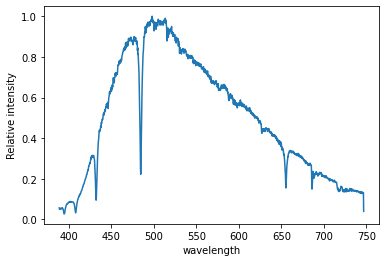

In [171]:
plt.xlabel("wavelength")
plt.ylabel("Relative intensity")
plt.plot( wavelengths, vega_sum * coeff / np.max(vega_sum * coeff) )

Earth spectrum

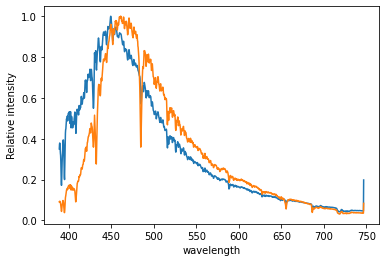

In [172]:
plt.xlabel("wavelength")
plt.ylabel("Relative intensity")
plt.plot( wavelengths, spectrum / np.max(spectrum) )
plt.plot( wavelengths, spectrum * coeff / np.max(spectrum * coeff) )

Crude method

In [176]:

print(wavelength_peak := get_peak_wavelength(wavelengths, spectrum * coeff)) # 481.6998282285298
print(T_eff := get_effective_temperature(wavelength_peak)) # 6015.72137913495
print("%f%% deviation from the accepted value." % float( ( T_eff / T_accepted ) * 100 - 100) ) #4.22% error

461.256792916
6282.339901556131
8.841648% deviation from the accepted value.
